In [1]:
import h5py, numpy, astropy.time, pylab
from pycbc.events.veto import start_end_to_segments, indices_within_times

f = h5py.File('./summO3b.hdf', 'r')

bins = numpy.arange(2.0, 30.0, .1)
ifos = ['H1', 'L1', 'V1']
types = [ 'H1L1V1', 'H1L1', 'H1V1', 'L1V1']

In [2]:
# get the population prior
from scipy.interpolate import interp1d
from pycbc.conversions import mchirp_from_mass1_mass2

pop = h5py.File('./simplepopprior.hdf', 'r')
popmc = pop['mchirp'][:]
popprior = pop['prior'][:]
popp = interp1d(popmc, popprior, bounds_error=False)

def reweight_pop(stat, template):
    b = h5py.File('./bbh2.hdf', 'r')
    m1 = b['mass1'][:][template]
    m2 = b['mass2'][:][template]
    mc = mchirp_from_mass1_mass2(m1, m2)
    
    popt = numpy.log(popp(mc))
    #popt = 0
    return(stat + popt)

def reweight_pop2(stat, mc):
    popt = numpy.log(popp(mc))
    #popt = 0
    return(stat + popt)

84.58421052631577 1.0
95.54872717387173 1.1296284091242381
11.30154212445153 0.13361290545988366
18.49222579748303 0.21862503276222858
{'H1L1V1': 2492383.5986011256, 'H1L1': 2815467.319415133, 'H1V1': 333014.6141296568, 'L1V1': 544897.4459002123}


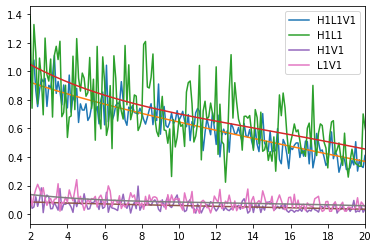

In [3]:
########## Calculate the expected foreground rates ###################
from pycbc.pnutils import chirp_distance

finj = h5py.File('./summO3.hdf', 'r')

# prepoulate some segment info
tstart = {}
tend = {}
for t in types:
    tstart[t] = []
    tend[t] = []

segs = {}
for chunk in finj.keys():
    chunk = str(chunk)
    
    csegs = {}
    for t in types:
        if t in finj[chunk]['background']:
            s = finj[chunk]['background'][t]['start'][:]
            e = finj[chunk]['background'][t]['end'][:]
            csegs[t] = s, e
            
        tstart[t].append(s)
        tend[t].append(e)
        
    segs[chunk] = csegs
    
for t in types:
    tstart[t] = numpy.concatenate(tstart[t])
    tend[t] = numpy.concatenate(tend[t])
    
def get_on(time):
    for t in types:
        x = indices_within_times(numpy.array([time]), tstart[t], tend[t])
        if len(x) != 0:
            return t

fac = 365.25 / 95.0
count = 22
nexpect = count * fac
nthresh = 20

stats = []
dists = []
times = []
ifars = []
mchirps = []
for chunk in finj.keys():
    chunk = str(chunk)

    #stat = finj[chunk]['inj/stat'][:]
    dist = finj[chunk]['inj/dist'][:]
    time = finj[chunk]['inj/time'][:]
    ifar = finj[chunk]['inj/ifar_exc'][:]
    mc = finj[chunk]['inj/mchirp'][:]
    stat = reweight_pop2(finj[chunk]['inj/stat'][:], mc)
    stats.append(stat)
    dists.append(dist)
    times.append(time)
    ifars.append(ifar)
    mchirps.append(mc)

stats = numpy.concatenate(stats)
dists = numpy.concatenate(dists)
times = numpy.concatenate(times)
ifars = numpy.concatenate(ifars)
mchirps = numpy.concatenate(mchirps)

cdist = chirp_distance(dists, mchirps)
#pylab.hist(cdist)

which = {}
vave = {}
sig = {}

for t in types:
    x = indices_within_times(times, tstart[t], tend[t])
    
    if 'H1L1V1' in which:
        keep = ~numpy.isin(x, which['H1L1V1'])
        which[t] = x[keep]
    else:
        which[t] = x
    
    w = cdist[which[t]] ** 2.0
    l = ifars[which[t]] > 10.0
    d = cdist[which[t]]
    dave = (w[l] * d[l]).sum() / w[l].sum()
    vave[t] = dave ** 3.0
    
    nw = nexpect / w[stats[which[t]] > nthresh].sum()
    
    nr = vave[t] / vave['H1L1V1']
    
    c, _ = numpy.histogram(stats[which[t]], weights=nw * w * nr, bins=bins)
    
    l =  numpy.searchsorted(bins, nthresh)
    v = (w * nr * nw)[stats[which[t]] > nthresh].sum()
    print(v, nr)
    
    pylab.plot(bins[:-1], c, label=t)
    
    cv = (bins[:-1] + bins[1:]) / 2.0
    p = numpy.polyfit(cv, c, 4)
    
    ybin = numpy.polyval(p, bins)
    pylab.plot(bins, ybin)
    
    pylab.xlim(2, 20)
    sig[t] = ybin
    
print(vave)
pylab.legend()

In [4]:
# prepoulate some segment info
tstart = {}
tend = {}
for t in types:
    tstart[t] = []
    tend[t] = []

segs = {}
for chunk in f.keys():
    chunk = str(chunk)
    
    csegs = {}
    for t in types:
        if t in f[chunk]['background']:
            s = f[chunk]['background'][t]['start'][:]
            e = f[chunk]['background'][t]['end'][:]
            csegs[t] = s, e
            
        tstart[t].append(s)
        tend[t].append(e)
        
    segs[chunk] = csegs
    
for t in types:
    tstart[t] = numpy.concatenate(tstart[t])
    tend[t] = numpy.concatenate(tend[t])
    
def get_on(time):
    for t in types:
        x = indices_within_times(numpy.array([time]), tstart[t], tend[t])
        if len(x) != 0:
            return t

In [5]:
########## Calculate the expected background rates ###################

import pylab

def get_back(chunk, active):
    chunk = str(chunk)    
    stat = reweight_pop(f[chunk]['background/stat'][:], f[chunk]['background/tid'][:])
    dec = f[chunk]['background/dec'][:]
    
    tid = {}
    for ifo in ifos:
        if ifo in f[chunk]['background']:
            tid[ifo] = f[chunk]['background'][ifo]['trig'][:]

    on = {ifo: tid[ifo] != -1 for ifo in tid}

    keep = None
    for j in range(len(active) // 2):
        ifo = active[j*2:j*2 + 2]
        
        if keep is None:
            keep = on[ifo]
        else:
            keep = keep & on[ifo]
            
    stat = stat[keep]
    dec = dec[keep]
    
    btime = f[chunk]['background'][active].attrs['background_time_exc'] / 365.25 / 86400.
    w = dec / btime
    
    le = bins[:-1]
    re = bins[1:]
    
    c, _ = numpy.histogram(stat, weights=w, bins=bins)
    #pylab.plot(bins[:-1], c)
    #pylab.yscale('log')
    #pylab.xlim(2, 20)
    #pylab.show()
    return c

In [6]:
num = 0
for chunk in f.keys():
    chunk = str(chunk)
    
    for i, stat in enumerate(f[chunk]['stat'][:]):
        # get event time
        
        stat = reweight_pop(stat, f[chunk]['tid'][i])
        if stat < 2.0:
            continue
            
        times = {}
        for ifo in ifos:
            if ifo in f[chunk]:
                times[ifo] = f[chunk][ifo]['time'][i]
        used = [k for k in times if times[k] != -1]
        used = ''.join(used)
        atime = numpy.mean([times[k] for k in times if times[k] != - 1])
             
        # determine which detectors were actually on at this time
        on = get_on(atime)
        
        # get the background and calculate the expectation for 1 year 
        if len(on) == 6:
            bnum = get_back(chunk, 'H1L1')
            #bnum += get_back(chunk, 'H1V1')
            #bnum += get_back(chunk, 'L1V1')
            bnum += get_back(chunk, 'H1L1V1')
            
            if used in ['H1V1', 'L1V1']:
                continue
        else:
            bnum = get_back(chunk, on) 
            
        # get the expected foreground counts for this type per year
        fnum = sig[on]   
        #print(fnum.sum(), bnum.sum())
        
        bnum[bnum == 0] = bnum[bnum != 0].min()         # limit in case of zero values
        
        
        #calculate pastro
        if (bins > stat).sum() == 0:
            fn = 100000
            bn = 1
        else:
            l = numpy.searchsorted(bins, stat) - 1
            fn = fnum[l]
            bn = bnum[l]
            
        #print(fn, bn)
        
        pastro = fn / (fn + bn)
    
        min_pastro = fnum[0] / (fnum[0] + bnum[0])
        
        #print(stat, fn, bn)
        
        ta = astropy.time.Time(atime, format='gps', scale='utc').datetime
        if pastro > 0.2:
            print('%2.2f %s %2.2f %s %s %2.2f' % (atime, ta, stat, used, on, pastro))
            num += 1      

1266645879.40 2020-02-25 06:04:21.398193 37.92 H1L1 H1L1 1.00
1266618172.40 2020-02-24 22:22:34.400146 83.06 H1L1 H1L1V1 1.00
1267132237.66 2020-03-01 21:10:19.661133 4.70 H1L1 H1L1 0.43
1262353301.93 2020-01-06 13:41:23.925293 5.41 H1L1 H1L1V1 0.69
1256999739.93 2019-11-05 14:35:21.930664 16.68 H1L1 H1L1V1 1.00
1256772098.02 2019-11-02 23:21:20.023926 3.25 H1L1 H1L1V1 0.22
1263744929.34 2020-01-22 16:15:11.340820 3.22 H1L1 H1L1 0.27
1257906499.42 2019-11-16 02:28:01.423828 3.52 H1L1 H1L1V1 0.22
1260567236.48 2019-12-16 21:33:38.479248 63.24 H1V1 H1V1 1.00
1260484270.33 2019-12-15 22:30:52.333740 26.43 H1L1 H1L1V1 1.00
1267381378.62 2020-03-04 18:22:40.619141 3.02 H1L1 H1L1 0.28
1267433277.08 2020-03-05 08:47:39.077393 4.86 H1L1 H1L1V1 0.59
1267522652.12 2020-03-06 09:37:14.125000 4.08 H1L1 H1L1 0.51
1258804397.63 2019-11-26 11:52:59.631104 11.02 H1L1 H1L1 1.00
1258866165.55 2019-11-27 05:02:27.552246 10.40 H1L1 H1L1V1 0.99
1259070047.20 2019-11-29 13:40:29.199219 41.85 H1L1 H1L1 1.00


In [7]:
cstart = numpy.zeros(len(f.keys()))
cend = numpy.zeros(len(f.keys()))
for k in f.keys():
    s = numpy.inf
    e = -numpy.inf
    for t in types:
        try:
            s = min(s, f[k]['background'][t]['start'][:].min())
            e = max(e, f[k]['background'][t]['end'][:].max())
        except:
            pass
    cstart[int(k)] = s
    cend[int(k)] = e


def get_chunk(time):
    x = numpy.where((time > cstart) & (time < cend))[0]
    if len(x) == 1:
        return x[0]
    else:
        return -1


ptarget = 0.9
atime = 1170079035.73
times = numpy.arange(cstart.min()+1, cend.max()-1, 100000)

for atime in times:
    stats = numpy.arange(3, 12, .1)
    chunk = get_chunk(atime)

    # determine which detectors were actually on at this time
    on = get_on(atime)

    if on is None:
        continue
    
    # get the background and calculate the expectation for 1 year 
    if len(on) == 6:
        bnum = get_back(chunk, 'H1L1')
        bnum += get_back(chunk, 'H1L1V1')
    else:
        bnum = get_back(chunk, on) 

    # get the expected foreground counts for this type per year
    fnum = sig[on]   
    #print(fnum.sum(), bnum.sum())

    bnum[bnum == 0] = bnum[bnum != 0].min()         # limit in case of zero values


    #calculate pastro
    for stat in stats:
        if (bins > stat).sum() == 0:
            fn = 100000
            bn = 1
        else:
            l = numpy.searchsorted(bins, stat) - 1
            fn = fnum[l]
            bn = bnum[l]

        pastro = fn / (fn + bn)
        if pastro > ptarget:
            stat_threshold = stat
            break
        
    print(stat_threshold)

6.800000000000003
7.5000000000000036
6.700000000000003
6.700000000000003
7.5000000000000036
7.300000000000004
8.100000000000005
8.100000000000005
7.400000000000004
7.700000000000005
7.800000000000004
7.800000000000004
7.700000000000005
7.800000000000004
7.600000000000004
7.5000000000000036
7.600000000000004
7.5000000000000036
7.5000000000000036
7.300000000000004
7.300000000000004
7.200000000000004
7.200000000000004
7.0000000000000036
7.200000000000004
7.200000000000004
7.300000000000004
7.300000000000004
7.300000000000004
7.600000000000004
7.600000000000004
7.600000000000004
7.600000000000004
7.100000000000003
7.800000000000004
7.100000000000003
6.600000000000003
6.700000000000003
7.200000000000004
7.200000000000004
7.200000000000004
6.700000000000003
6.700000000000003
6.200000000000003
6.200000000000003
6.900000000000004
6.900000000000004
7.100000000000003
7.100000000000003
7.100000000000003
7.100000000000003
7.100000000000003
7.100000000000003
7.100000000000003
6.800000000000003
7.20